In [ ]:
# load offline trained agent
# load expert agent
# write ensemble class for offline trained agents
# use distributional RL to detect risky states
# use ensembles to detect novel states
# if novelty is above a treshold give control to expert 
# if risk is above a treshold give control to expert
# can conformal prediction give us guaranties about the performance in this setu?p
# empirecally verify if we are able to get the desired performance

In [1]:
import re
import os
import argparse
import torch
from torch import nn
import numpy as np
import gymnasium as gym
from types import SimpleNamespace
from matplotlib import pyplot as plt

from examples.offline.utils import load_buffer_d4rl
from tianshou.policy import DSACPolicy, BasePolicy
from tianshou.data.buffer.vecbuf import VectorReplayBuffer
from tianshou.env import SubprocVectorEnv
from tianshou.data import Collector, Batch, to_torch
from tianshou.data.types import RolloutBatchProtocol
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import ActorProb, QuantileMlp
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shim

In [2]:
device = "cuda"
seed = 0
np.random.seed(seed);
torch.manual_seed(seed);

In [3]:
def parse_value(value):
    # Convert simple types (int, float, bool, None)
    if value.isdigit():
        return int(value)
    elif re.match(r'^\d+\.\d+$', value):
        return float(value)
    elif value == "True":
        return True
    elif value == "False":
        return False
    elif value == "None":
        return None
    elif value.startswith("[") and value.endswith("]"):
        # Convert the list items
        items = re.split(r',(?=[^\]]*(?:\[|$))', value[1:-1])
        return [parse_value(item.strip()) for item in items]
    elif value.startswith("(") and value.endswith(")"):
        # Convert the tuple items
        items = re.split(r',(?=[^\)]*(?:\(|$))', value[1:-1])
        # Special case for single-item tuple
        if len(items) == 2 and items[0].strip() != '':
            return (parse_value(items[0].strip()),)
        return tuple(parse_value(item.strip()) for item in items)
    elif value.startswith("'") and value.endswith("'"):
        return value[1:-1]
    # Else, return the value as-is
    return value

def get_args(event_file):
    ea = EventAccumulator(event_file)
    ea.Reload()  # Load the file
    # Get the text data
    texts = ea.Tags()["tensors"]
    # Extract the actual text content
    text_data = {}
    for tag in texts:
        events = ea.Tensors(tag)
        for event in events:
            # You can extract the wall_time and step if needed
            # wall_time, step, value = event.wall_time, event.step, event.text
            text_data[tag] = event.tensor_proto.string_val
    data = text_data['args/text_summary'][0]
    # Convert bytes to string
    data_str = data.decode('utf-8')
    # Remove the "Namespace(" prefix and the trailing ")"
    data_str = data_str[len("Namespace("):-1]
    # Split into key-value pairs
    key_values = re.split(r',(?=\s\w+=)', data_str)
    # Parse each key-value pair
    args_dict = {}
    for kv in key_values:
        key, value = kv.split('=', 1)
        key = key.strip()
        args_dict[key] = parse_value(value)
    args = SimpleNamespace(**args_dict)
    try:
        env = gym.make(args.task)
        target_entropy = -np.prod(env.action_space.shape)
        log_alpha = torch.zeros(1, requires_grad=True, device=device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        args.alpha = (target_entropy, log_alpha, alpha_optim)
    except Exception:
        pass
    return args

In [4]:
def get_dsac_args():
    args = argparse.Namespace(
        task="HalfCheetah-v2",
        risk_type="wang",
        buffer_size=1000000,
        hidden_sizes=[256, 256, 256],
        # hidden_sizes=[256, 256],
        actor_lr=3e-4,
        critic_lr=3e-4,
        gamma=0.99,
        tau=0.005,
        alpha=0.4,
        start_timesteps=1,
        epoch=200,
        step_per_epoch=5000,
        step_per_collect=1,
        update_per_step=1,
        batch_size=256,
        training_num=1,
        test_num=10,
        distortion_param=0.75,
    )
    return args

In [5]:
def load_policy(args, path):
    env = gym.make(args.task)
    args.state_shape = env.observation_space.shape or env.observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n
    # model
    net_a = Net(args.state_shape, hidden_sizes=args.hidden_sizes, device=device)
    actor = ActorProb(
        net_a,
        args.action_shape,
        device=device,
        unbounded=True,
        conditioned_sigma=True,
    ).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=args.actor_lr)
    critic1 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
    critic2 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)
    policy = DSACPolicy(
        actor,
        actor_optim,
        critic1,
        critic1_optim,
        critic2,
        critic2_optim,
        risk_type='wang',
        tau=args.tau,
        gamma=args.gamma,
        alpha=0.4,
        action_space=env.action_space,
        device=device,
        distortion_param=0.75,
    )
    dirname = os.path.dirname(path)
    if os.path.isfile(os.path.join(dirname, "actor.pth")):
        policy.actor.load_state_dict(torch.load(os.path.join(dirname, "actor.pth"), map_location=device))
        print("Loaded actor from: ", os.path.join(dirname, "actor.pth"))
    if os.path.isfile(os.path.join(dirname, "critic1.pth")):
        policy.critic1.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        policy.critic1_old.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        print("Loaded critic1 from: ", os.path.join(dirname, "critic1.pth"))
    if os.path.isfile(os.path.join(dirname, "critic2.pth")):
        policy.critic2.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        policy.critic2_old.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        print("Loaded critic2 from: ", os.path.join(dirname, "critic2.pth"))
    else:
        policy.load_state_dict(torch.load(path, map_location=device))
        print("Loaded agent from: ", path)
    return policy

def load_behavioral_crtitic(args, path):
    behavioral_critic = QuantileMlp(
        input_size=args.state_shape[0] + args.action_shape[0],
        hidden_sizes=args.hidden_sizes,
        device=device,
    ).to(device)
    behavioral_critic.load_state_dict(torch.load(path, map_location=device))
    return behavioral_critic

def get_model(log_path, type=None):
    if type == "behavioral":
        files = os.listdir(log_path)
        event_file = [f for f in files if f.startswith('event')][0]
        full_path = os.path.join(log_path, event_file)
        args = get_args(full_path)
        resume_path = os.path.join(log_path, 'model.pth')
        policy = load_behavioral_crtitic(args, resume_path)
    elif type == "codac":
        files = os.listdir(log_path)
        event_file = [f for f in files if f.startswith('event')][0]
        full_path = os.path.join(log_path, event_file)
        args = get_args(full_path)
        resume_path = os.path.join(log_path, 'policy.pth')
        policy = load_policy(args, resume_path)
    else:
        args = get_dsac_args()
        resume_path = os.path.join(log_path, 'policy.pth')
        policy = load_policy(args, resume_path)
    return policy

In [6]:
log_path = "/data/user/R901105/dev/log/HalfCheetah-v4/qr/231127-112017"
behavioral_critic = get_model(log_path, "behavioral")

In [7]:
log_path1 = "/data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231127-113302"
offline_policy1 = get_model(log_path1)

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


Loaded actor from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231127-113302/actor.pth
Loaded critic1 from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231127-113302/critic1.pth
Loaded critic2 from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231127-113302/critic2.pth


In [8]:
log_path2 = "/data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/123/231127-124113"
offline_policy2 = get_model(log_path2)

Loaded actor from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/123/231127-124113/actor.pth
Loaded critic1 from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/123/231127-124113/critic1.pth
Loaded critic2 from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/123/231127-124113/critic2.pth


/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [9]:
log_path3 = "/data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231204-225919"
offline_policy3 = get_model(log_path3)

Loaded actor from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231204-225919/actor.pth
Loaded critic1 from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231204-225919/critic1.pth
Loaded critic2 from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231204-225919/critic2.pth


In [10]:
log_path = "/data/user/R901105/dev/halfcheetah_expert"
expert_policy = get_model(log_path) 
expert_policy.eval();

Loaded actor from:  /data/user/R901105/dev/halfcheetah_expert/actor.pth
Loaded critic1 from:  /data/user/R901105/dev/halfcheetah_expert/critic1.pth
Loaded critic2 from:  /data/user/R901105/dev/halfcheetah_expert/critic2.pth


In [11]:
class DeterministicPolicy(BasePolicy):
    def __init__(self, policy, action_space):
        super().__init__(action_space=action_space)
        self.policy = policy

    def train(self, mode: bool = True) -> "DeterministicPolicy":
        self.policy.eval()
        return self
    
    def forward(self, batch, state=None, **kwargs):
        return self.policy(batch)
    
    def learn(self, batch, **kwargs):
        info = self.policy.learn(batch)
        return info

In [12]:
import torch
import random

class EnsemblePolicy(BasePolicy):
    def __init__(self, policies, action_space):
        super().__init__(action_space=action_space)
        self.policies = policies

    def forward(self, batch, state=None, **kwargs):
        return self.policies[0](batch)
    
    def learn(self, batch, **kwargs):
        policy = random.choice(self.policies)
        info = policy.learn(batch)
        # for policy in self.policies:
        #     info = policy.learn(batch)
        return info
    
    def bc(self, batch):
        policy = random.choice(self.policies)
        pred_act = policy.actor(batch.obs)
        expert_act = batch.act
        loss = (pred_act - expert_act).pow(2).mean()
        policy.actor_optim.zero_grad()
        loss.backward()
        policy.actor_optim.step()
        return loss

    def get_qvalues(self, obs, act):
        q_values = torch.stack([p.critic1(obs, act).detach() for p in self.policies])
        return q_values
    
    def train(self, mode: bool = True) -> "EnsemblePolicy":
        for policy in self.policies:
            policy.train(mode)
        return self

In [13]:
task = "HalfCheetah-v2"
env_num = 20
env = gym.make(task)

In [14]:
policies = [offline_policy1, offline_policy2, offline_policy3]
# policies = [offline_policy1]

In [15]:
ensemble = EnsemblePolicy(policies, env.action_space)

In [16]:
offline_data = load_buffer_d4rl("halfcheetah-medium-v2")

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|██████████| 21/21 [00:01<00:00, 11.08it/s]


# give control to the expert policy based on epistemic and aleatoric uncertainties

In [29]:
class MixedPolicy(BasePolicy):
    def __init__(self, ensemble: EnsemblePolicy, expert_policy: BasePolicy, old_critic: QuantileMlp, action_space, config="nr"):
        super().__init__(action_space=action_space)
        self.ensemble = ensemble
        self.expert_policy = expert_policy
        self.old_critic = old_critic
        self.config = config

    def update_results(self, batch: RolloutBatchProtocol):
        self.ensemble_result = self.ensemble(batch)
        self.expert_result = self.expert_policy(batch)
        actions = self.ensemble_result.act
        expert_actions = self.expert_result.act
        self.q_values = self.ensemble.get_qvalues(batch.obs, actions) # (n_policies, bsz, n_taus)
        self.expert_q_values = self.expert_policy.critic1(batch.obs, expert_actions)

    def update_novelty_threshold(self, buffer, step=0, decay=0.9, start=0.89):
        batch, _ = buffer.sample(25000)
        batch = to_torch(batch, dtype=torch.float32, device=device)
        q_values = self.ensemble.get_qvalues(batch.obs, batch.act)
        data_epistemic_uncert = torch.std(q_values, 0).mean(-1).detach().cpu().numpy()
        pecentile = 1 - (1 -start) * (decay**step)
        self.novelty_threshold = np.quantile(data_epistemic_uncert, pecentile)

    def get_uncertainties(self):
        epistemic_uncert = torch.std(self.q_values, 0).mean(-1) # bsz
        aleatoric_uncert = torch.std(self.q_values, -1).mean(0) # bsz
        return epistemic_uncert, aleatoric_uncert

    # def cede_control(self):
    #     epistemic_uncert, aleatoric_uncert = self.get_uncertainties()
    #     novelty = epistemic_uncert > self.novelty_threshold
    #     risk = (self.q_values.mean((0, 2)) - aleatoric_uncert) < self.expert_q_values.mean(-1)
    #     return novelty, risk

    def cede_control(self):
        risk = self.q_values.mean((0, 2)) < 0.9*self.expert_q_values.mean(-1)
        return None , risk

    def take_control(self):
        ensemble_actions = self.ensemble_result.act
        expert_actions = self.expert_result.act
        expert_std = self.expert_result.dist.base_dist.scale
        return torch.any(abs(ensemble_actions-expert_actions) < expert_std/2, dim=1)

    def forward(self, batch: RolloutBatchProtocol, state=None, **kwargs):
        batch = to_torch(batch, dtype=torch.float32, device=device)
        self.update_results(batch)
        novelty, risk = self.cede_control()
        if self.config == "n":
            cede_ctrl = novelty
        elif self.config == "r":
            cede_ctrl = risk
        elif self.config == "nr":
            cede_ctrl = torch.logical_or(novelty, risk)
        else:
            cede_ctrl = torch.zeros_like(novelty)
        cede_ctrl = cede_ctrl.unsqueeze(-1)
        actions = torch.where(cede_ctrl, self.expert_result.act, self.ensemble_result.act)
        return Batch(**{'act': actions, 'policy': Batch({'cede_ctrl': cede_ctrl})})

    def train(self, mode: bool = True) -> "MixedPolicy":
        self.ensemble.train(mode)
        return self

    def learn(self, batch, **kwargs):
        # cede_ctrl = batch.policy.cede_ctrl.cpu().squeeze()
        # ensemble_batch = batch[~cede_ctrl]
        # if len(ensemble_batch) > 0:
        #     info = self.ensemble.learn(ensemble_batch)
        # else:
        #     info = {}
        # online_batch = batch
        # offline_batch, _ = offline_data.sample(20*len(batch))
        # _batch = Batch.cat([online_batch, offline_batch])
        info = self.ensemble.learn(batch)
        return info

In [18]:
class MixPolicy(BasePolicy):
    def __init__(self, base_policy: BasePolicy, expert_policy: BasePolicy, od_detector: nn.Module, action_space):
        super().__init__(action_space=action_space)
        self.base = base_policy
        self.expert = expert_policy
        self.od_detector = od_detector

    def update_results(self, batch: RolloutBatchProtocol):
        self.base_result = self.base(batch)
        self.expert_result = self.expert(batch)
        self.od_result = self.od_detector(batch.obs)

    def cede_control(self):
        return 1-self.od_result

    def forward(self, batch: RolloutBatchProtocol, state=None, **kwargs):
        batch = to_torch(batch, dtype=torch.float32, device=device)
        self.update_results(batch)
        cede_ctrl = self.cede_control()
        actions = torch.where(cede_ctrl, self.expert_result.act, self.ensemble_result.act)
        return Batch(**{'act': actions, 'policy': Batch({'cede_ctrl': cede_ctrl})})

    def train(self, mode: bool = True) -> "MixPolicy":
        self.base.eval()
        return self

    def learn(self, batch, **kwargs):
        info = self.base.learn(batch)
        return info

# estimate novelty_threshold from the data

In [18]:
# from tianshou.data.buffer.base import ReplayBuffer

# def add_policy_id(buffer: ReplayBuffer) -> ReplayBuffer:
#     data_dict = buffer._meta.__dict__
#     new_data_dict = data_dict.copy()
#     new_data_dict["policy"] = Batch(**{'id': np.full(buffer.rew.shape, -1)})
#     new_batch = Batch(**new_data_dict)
#     buffer._meta = new_batch
#     return buffer

In [19]:
# offline_data = add_policy_id(offline_data)

In [21]:
# batch, _ = offline_data.sample(10)
# batch

In [19]:
offline_batch, _ = offline_data.sample(25000)
offline_batch = to_torch(offline_batch, dtype=torch.float32, device=device)
q_values = ensemble.get_qvalues(offline_batch.obs, offline_batch.act)
data_epistemic_uncert = torch.std(q_values, 0).mean(-1).detach().cpu().numpy()

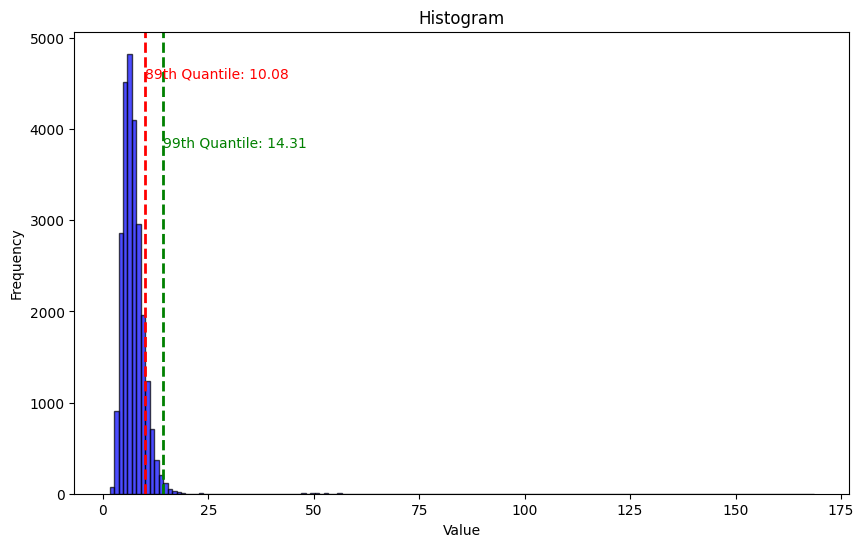

In [20]:
num_bins = int(np.sqrt(data_epistemic_uncert.size))
data_range = (np.min(data_epistemic_uncert), np.max(data_epistemic_uncert))
quantile_89 = np.quantile(data_epistemic_uncert, 0.89)
quantile_99 = np.quantile(data_epistemic_uncert, 0.99)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(data_epistemic_uncert, bins=num_bins, range=data_range, color='blue', edgecolor='black', alpha=0.7)
# Plot a vertical line for the 89% quantile
plt.axvline(quantile_89, color='red', linestyle='dashed', linewidth=2)
plt.axvline(quantile_99, color='green', linestyle='dashed', linewidth=2)
# Annotate the 89% quantile value on the plot
plt.text(quantile_89, plt.ylim()[1]*0.9, f'89th Quantile: {quantile_89:.2f}', color='red')
plt.text(quantile_99, plt.ylim()[1]*0.75, f'99th Quantile: {quantile_99:.2f}', color='green')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Establish baselines

In [21]:
mix_policy_nr = MixedPolicy(ensemble, expert_policy, behavioral_critic, env.action_space)
mix_policy_n = MixedPolicy(ensemble, expert_policy, behavioral_critic, env.action_space, "n")
mix_policy = MixedPolicy(ensemble, expert_policy, behavioral_critic, env.action_space, "")
mix_policy_nr.update_novelty_threshold(offline_data)
mix_policy_n.update_novelty_threshold(offline_data)
mix_policy.update_novelty_threshold(offline_data)

In [22]:
envs = SubprocVectorEnv([lambda: gym.make(task) for _ in range(20)])

In [17]:
op_collector = Collector(offline_policy1, envs)
op_collector.collect(n_episode=40)

{'n/ep': 40,
 'n/st': 40000,
 'rews': array([4861.25123787, 4587.06964968, 4534.28378431, 4457.82757447,
        4503.90128177, 4185.88310027, 4675.28780686, 4233.74953302,
        4097.39982837, 4570.62058909, 3427.38962896, 4412.58567319,
        4849.58622708, 4818.72679523, 4026.32644639, 4750.54978905,
        4577.85029425, 4623.40553575, 4123.86082648, 4580.63307277,
        4559.47116807, 4563.45771756, 4765.02012956, 4944.46879158,
        4833.58586656, 4527.12571751, 4639.44368305, 4569.56132308,
        4088.32253109, 4503.86095053, 4459.76761175, 4573.57119094,
        4119.7871919 , 4703.84845701, 3849.20943889, 4617.15584606,
        4751.27174055, 4721.87837877, 4853.08278055, 4610.35646229]),
 'lens': array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000]),

In [27]:
mix_buffer = VectorReplayBuffer(20000, 20)
mix_buffer_n = VectorReplayBuffer(20000, 20)
mix_buffer_nr = VectorReplayBuffer(20000, 20)

ens_collector = Collector(ensemble, envs)
exp_collector = Collector(expert_policy, envs)
mix_collector = Collector(mix_policy, envs, mix_buffer)
mix_collector_n = Collector(mix_policy_n, envs, mix_buffer_n)
mix_collector_nr = Collector(mix_policy_nr, envs, mix_buffer_nr)

ens_result = ens_collector.collect(n_episode=40)
# exp_result = exp_collector.collect(n_episode=40)
# mix_result = mix_collector.collect(n_episode=40)
# mix_result_n = mix_collector_n.collect(n_episode=40)
# mix_result_nr = mix_collector_nr.collect(n_episode=40)

# ens_baseline = ens_result["rew"]

# ens_result["rew"], exp_result["rew"], mix_result["rew"], mix_result_n["rew"], mix_result_nr["rew"]
ens_result

{'n/ep': 40,
 'n/st': 40000,
 'rews': array([4352.14895172, 4496.61104164, 4542.4159473 , 4509.05784289,
        4344.24581596, 4812.278767  , 4890.48329849, 4790.8731387 ,
        4323.52308048, 4575.40862159, 4567.62842772, 4729.67602471,
        4805.64195757, 4849.8561668 , 4444.10678548, 4895.62640168,
        4429.70091472, 4458.75371727, 4555.93538403, 4448.47098945,
        4327.10597405, 4664.80252436, 4891.05007501, 4503.21708405,
        4780.58581933, 4273.9563884 , 4813.4731181 , 4598.562078  ,
        4583.38931156, 4338.73452948, 4477.85819315, 4850.25245577,
        4791.83259071, 4678.04347364, 4579.7055238 , 4821.44560657,
        4431.30873021, 4661.74918346, 4720.06984182, 3979.88458976]),
 'lens': array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000]),

In [ ]:
mix_buffer.policy.cede_ctrl.cpu().float().mean(), mix_buffer_n.policy.cede_ctrl.cpu().float().mean(), mix_buffer_nr.policy.cede_ctrl.cpu().float().mean()

In [ ]:
batch, _ = mix_buffer_nr.sample(0)
batch.policy.cede_ctrl.cpu().float().mean()

# check the performance of the ensemble + expert in comparaison with only the ensemble

In [ ]:
def evaluate_policies(ensemble, expert_policy, behavioral_critic, novelty_threshold, n_episode):
    mix_policy = MixedPolicy(ensemble, expert_policy, behavioral_critic, env.action_space, novelty_threshold)
    mix_collector = Collector(mix_policy, env)
    mix_result = mix_collector.collect(n_episode=n_episode)
    improvement = (mix_result['rew'] - ens_baseline) / mix_result['rew']
    return mix_result['rew'], mix_policy.expert_calls.mean(), improvement    

In [45]:
def calculate_discounted_accumulated_rewards(policy: BasePolicy, env_name: str, gamma: float) -> float:
    """
    Run a Tianshou policy in a given environment and calculate the discounted accumulated rewards.

    :param policy: Tianshou policy to be evaluated.
    :param env_name: Name of the gym environment.
    :param gamma: Discount factor for future rewards.
    :return: Discounted accumulated reward.
    """
    # Create the environment
    env = gym.make(env_name)
    state, _ = env.reset()

    done = False
    discounted_accumulated_reward = 0
    accumulated_reward = 0
    discount = 1

    # Run the policy in the environment
    while not done:
        # Predict the action given the current state
        action = policy(Batch(**{"obs": state[np.newaxis, ...], "info": 0})).act.squeeze().detach().cpu()

        # Take the action in the environment
        next_state, reward, truncated, terminated, _ = env.step(action)

        # Update the discounted accumulated reward
        discounted_accumulated_reward += reward * discount
        accumulated_reward += reward
        discount *= gamma

        # Move to the next state
        state = next_state
        done = truncated or terminated

    env.close()
    return discounted_accumulated_reward, accumulated_reward

In [47]:
calculate_discounted_accumulated_rewards(offline_policy1, "Hopper-v2", 0.99)

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Hopper-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x11 and 17x256)

# perform continual learning and observe the evolution of numbers of calls to the expert

In [ ]:
# this can be tricky as we need to do continual learning for all the policies in the ensemble

In [23]:
test_envs = SubprocVectorEnv([lambda: gym.make(task) for _ in range(5)])
test_envs.seed(seed);

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variable

In [49]:
det_policy = DeterministicPolicy(offline_policy1, env.action_space)

In [50]:
mixx = MixPolicy(det_policy, expert_policy, env.action_space)

In [30]:
mix_policy_r = MixedPolicy(ensemble, expert_policy, behavioral_critic, env.action_space, "r")
mix_policy_r.update_novelty_threshold(offline_data)

In [31]:
test_buffer = VectorReplayBuffer(5000, 5)
train_collector = Collector(mix_policy_r, env, offline_data)
test_collector = Collector(mix_policy_r, test_envs, test_buffer)

/data/user/R901105/dev/my_fork/tianshou/tianshou/data/collector.py:70: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


In [ ]:
train_collector.collect(n_step=10000)

In [32]:
import datetime
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = os.path.join(task, "dsac", "neutral", now)
log_path = os.path.join("../../log", log_name)
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [33]:
def test_fn(num_epoch: int, step_idx: int):
    if num_epoch > 0 :
        # mix_policy_nr.update_novelty_threshold(offline_data, step=num_epoch)
        print(test_buffer.policy.cede_ctrl.cpu().float().mean())

In [34]:
from tianshou.trainer import OffpolicyTrainer

result = OffpolicyTrainer(
    policy=mix_policy_r,
    train_collector=train_collector,
    test_collector=test_collector,
    test_fn=test_fn,
    max_epoch=200,
    step_per_epoch=500,
    step_per_collect=1,
    episode_per_test=5,
    batch_size=1024,
    logger=logger,
    update_per_step=1,
    test_in_train=False,
).run()

Epoch #1: 501it [00:18, 27.77it/s, env_step=500, gradient_step=500, len=0, loss/actor=-438.377, loss/critic1=8.656, loss/critic2=8.655, n/ep=0, n/st=1, rew=0.00]                         


tensor(1.)
Epoch #1: test_reward: 8743.714185 ± 38.840428, best_reward: 8780.545532 ± 23.223626 in #0


Epoch #2: 501it [00:18, 27.40it/s, env_step=1000, gradient_step=1000, len=1353, loss/actor=-437.117, loss/critic1=8.566, loss/critic2=8.565, n/ep=1, n/st=1, rew=11687.88]                         


tensor(1.)
Epoch #2: test_reward: 8762.076868 ± 60.035671, best_reward: 8780.545532 ± 23.223626 in #0


Epoch #3: 501it [00:18, 27.61it/s, env_step=1500, gradient_step=1500, len=1353, loss/actor=-435.715, loss/critic1=8.468, loss/critic2=8.467, n/ep=0, n/st=1, rew=11687.88]                         


tensor(1.)
Epoch #3: test_reward: 8791.711548 ± 65.005616, best_reward: 8791.711548 ± 65.005616 in #3


Epoch #4: 501it [00:18, 27.68it/s, env_step=2000, gradient_step=2000, len=1000, loss/actor=-434.379, loss/critic1=8.362, loss/critic2=8.362, n/ep=1, n/st=1, rew=8821.95]                          


tensor(1.)
Epoch #4: test_reward: 8768.750872 ± 25.452285, best_reward: 8791.711548 ± 65.005616 in #3


Epoch #5: 501it [00:18, 27.55it/s, env_step=2500, gradient_step=2500, len=1000, loss/actor=-433.559, loss/critic1=8.287, loss/critic2=8.287, n/ep=0, n/st=1, rew=8821.95]                         


tensor(1.)
Epoch #5: test_reward: 8760.169083 ± 33.573139, best_reward: 8791.711548 ± 65.005616 in #3


Epoch #6: 501it [00:18, 27.50it/s, env_step=3000, gradient_step=3000, len=1000, loss/actor=-432.679, loss/critic1=8.204, loss/critic2=8.204, n/ep=1, n/st=1, rew=8791.12]                         


tensor(1.)
Epoch #6: test_reward: 8771.193704 ± 54.372225, best_reward: 8791.711548 ± 65.005616 in #3


Epoch #7: 501it [00:18, 27.50it/s, env_step=3500, gradient_step=3500, len=1000, loss/actor=-431.260, loss/critic1=8.124, loss/critic2=8.123, n/ep=0, n/st=1, rew=8791.12]                         


tensor(1.)
Epoch #7: test_reward: 8795.913056 ± 59.884823, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #8: 501it [00:18, 27.18it/s, env_step=4000, gradient_step=4000, len=1000, loss/actor=-430.551, loss/critic1=8.050, loss/critic2=8.049, n/ep=1, n/st=1, rew=8749.59]                         


tensor(1.)
Epoch #8: test_reward: 8731.267395 ± 47.452960, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #9: 501it [00:18, 27.44it/s, env_step=4500, gradient_step=4500, len=1000, loss/actor=-430.542, loss/critic1=7.991, loss/critic2=7.992, n/ep=0, n/st=1, rew=8749.59]                         


tensor(1.)
Epoch #9: test_reward: 8754.329930 ± 37.504617, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #10: 501it [00:18, 27.38it/s, env_step=5000, gradient_step=5000, len=1000, loss/actor=-429.997, loss/critic1=7.929, loss/critic2=7.928, n/ep=1, n/st=1, rew=8850.81]                         


tensor(1.)
Epoch #10: test_reward: 8772.517844 ± 48.090063, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #11: 501it [00:18, 27.47it/s, env_step=5500, gradient_step=5500, len=1000, loss/actor=-429.824, loss/critic1=7.874, loss/critic2=7.874, n/ep=0, n/st=1, rew=8850.81]                         


tensor(1.)
Epoch #11: test_reward: 8758.346790 ± 53.326115, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #12: 501it [00:18, 27.35it/s, env_step=6000, gradient_step=6000, len=1000, loss/actor=-429.689, loss/critic1=7.817, loss/critic2=7.817, n/ep=1, n/st=1, rew=8781.20]                         


tensor(1.)
Epoch #12: test_reward: 8790.454399 ± 19.774976, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #13: 501it [00:18, 27.17it/s, env_step=6500, gradient_step=6500, len=1000, loss/actor=-430.104, loss/critic1=7.763, loss/critic2=7.763, n/ep=0, n/st=1, rew=8781.20]                         


tensor(1.)
Epoch #13: test_reward: 8749.315614 ± 44.556904, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #14: 501it [00:18, 27.20it/s, env_step=7000, gradient_step=7000, len=1000, loss/actor=-429.501, loss/critic1=7.703, loss/critic2=7.703, n/ep=1, n/st=1, rew=8780.39]                         


tensor(1.)
Epoch #14: test_reward: 8784.209266 ± 50.146064, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #15: 501it [00:18, 27.45it/s, env_step=7500, gradient_step=7500, len=1000, loss/actor=-430.438, loss/critic1=7.657, loss/critic2=7.657, n/ep=0, n/st=1, rew=8780.39]                         


tensor(1.)
Epoch #15: test_reward: 8768.168276 ± 54.867876, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #16: 501it [00:18, 26.73it/s, env_step=8000, gradient_step=8000, len=1000, loss/actor=-430.446, loss/critic1=7.624, loss/critic2=7.623, n/ep=1, n/st=1, rew=8739.10]                         


tensor(1.)
Epoch #16: test_reward: 8739.327034 ± 35.339409, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #17: 501it [00:18, 27.06it/s, env_step=8500, gradient_step=8500, len=1000, loss/actor=-431.078, loss/critic1=7.583, loss/critic2=7.583, n/ep=0, n/st=1, rew=8739.10]                         


tensor(1.)
Epoch #17: test_reward: 8779.264351 ± 53.568757, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #18: 501it [00:18, 26.58it/s, env_step=9000, gradient_step=9000, len=1000, loss/actor=-431.708, loss/critic1=7.530, loss/critic2=7.529, n/ep=1, n/st=1, rew=8795.94]                         


tensor(1.)
Epoch #18: test_reward: 8778.550308 ± 52.349528, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #19: 501it [00:18, 26.55it/s, env_step=9500, gradient_step=9500, len=1000, loss/actor=-432.422, loss/critic1=7.509, loss/critic2=7.508, n/ep=0, n/st=1, rew=8795.94]                         


tensor(1.)
Epoch #19: test_reward: 8767.204033 ± 33.981249, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #20: 501it [00:18, 27.25it/s, env_step=10000, gradient_step=10000, len=1000, loss/actor=-434.071, loss/critic1=7.451, loss/critic2=7.451, n/ep=1, n/st=1, rew=8756.50]                         


tensor(1.)
Epoch #20: test_reward: 8742.564101 ± 33.016307, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #21: 501it [00:18, 27.20it/s, env_step=10500, gradient_step=10500, len=1000, loss/actor=-434.345, loss/critic1=7.415, loss/critic2=7.414, n/ep=0, n/st=1, rew=8756.50]                         


tensor(1.)
Epoch #21: test_reward: 8765.544625 ± 25.098822, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #22: 501it [00:18, 27.06it/s, env_step=11000, gradient_step=11000, len=1000, loss/actor=-434.951, loss/critic1=7.384, loss/critic2=7.384, n/ep=1, n/st=1, rew=8833.98]                         


tensor(1.)
Epoch #22: test_reward: 8782.290451 ± 43.840742, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #23: 501it [00:18, 27.20it/s, env_step=11500, gradient_step=11500, len=1000, loss/actor=-435.987, loss/critic1=7.360, loss/critic2=7.358, n/ep=0, n/st=1, rew=8833.98]                         


tensor(1.)
Epoch #23: test_reward: 8764.893263 ± 48.899207, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #24: 501it [00:18, 27.21it/s, env_step=12000, gradient_step=12000, len=1000, loss/actor=-437.298, loss/critic1=7.294, loss/critic2=7.293, n/ep=1, n/st=1, rew=8775.64]                         


tensor(1.)
Epoch #24: test_reward: 8791.018145 ± 6.776477, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #25: 501it [00:18, 27.11it/s, env_step=12500, gradient_step=12500, len=1000, loss/actor=-438.237, loss/critic1=7.250, loss/critic2=7.249, n/ep=0, n/st=1, rew=8775.64]                         


tensor(1.)
Epoch #25: test_reward: 8756.727597 ± 49.753440, best_reward: 8795.913056 ± 59.884823 in #7


Epoch #26:  85%|########5 | 426/500 [00:15<00:02, 26.71it/s, env_step=12925, gradient_step=12925, len=1000, loss/actor=-439.577, loss/critic1=7.212, loss/critic2=7.211, n/ep=0, n/st=1, rew=8775.64]


KeyboardInterrupt: 

In [36]:
mix_policy_r.q_values, mix_policy_r.expert_q_values

(tensor([[[545.0673, 562.5686, 568.5168, 571.4066, 575.6000, 579.4008, 582.0373,
           585.4357, 588.5088, 591.5640, 592.9493, 594.2272, 595.8409, 598.3125,
           601.0197, 605.1782]],
 
         [[546.1712, 553.7066, 567.0347, 579.1821, 586.2369, 590.5028, 594.5225,
           596.2476, 597.4871, 598.3288, 599.1767, 599.7960, 600.3356, 600.6666,
           600.8529, 601.9847]],
 
         [[537.5802, 559.9738, 571.1710, 578.7217, 584.5421, 588.6882, 591.4799,
           593.8772, 594.7488, 596.7670, 598.7935, 600.2566, 602.1553, 605.3320,
           607.4578, 611.3715]]], device='cuda:0'),
 tensor([[725.7118, 730.0748, 733.0227, 734.5841, 735.5822, 736.1691, 736.8743,
          737.5449, 737.7747, 738.0643, 738.3610, 738.6759, 738.6823, 739.0128,
          739.3438, 741.5106]], device='cuda:0'))

In [ ]:
batch, _ = test_buffer.sample(1)

In [ ]:
mix_policy(batch).policy.cede

In [38]:
offline_policy1.eval()
test_collector1 = Collector(offline_policy1, test_envs)
test_collector1.collect(n_episode=40)

{'n/ep': 40,
 'n/st': 40000,
 'rews': array([5955.42561977, 5960.14295851, 6345.67900197, 6452.10139581,
        6212.52859869, 6550.26161751, 6066.07010389, 6433.33568906,
        6350.11304232, 6544.81412222, 5570.7515739 , 6228.13801271,
        6050.16460722, 4135.43621449, 6278.55061001, 6330.75545796,
        6357.43226971, 6547.04719519, 6617.90720573, 6404.36953168,
        6328.90534876, 6366.14252353, 5955.41433545, 2509.63836869,
        6481.64620236, 6681.59705898, 6206.2879277 , 6255.91152185,
        6557.70295486, 6798.25913636, 6215.51608019, 4775.20809866,
        6309.71408314, 6464.83685722, 5958.31083627, 6403.75437122,
        6112.81654475, 6278.83882244, 5816.52311178, 6163.08860933]),
 'lens': array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000]),

In [32]:
test_collector2 = Collector(offline_policy2, test_envs)
test_collector2.collect(n_episode=40)

{'n/ep': 40,
 'n/st': 40000,
 'rews': array([7399.17203028, 7914.14273599, 7544.20808021, 7636.57072513,
         904.89063934, 7735.46514638, 7901.57782222, 7947.22028961,
        7745.99208287, 7258.08251182, 7973.68930226, 7762.74729772,
        7841.8240032 , 1566.82583688, 1484.69256004, 1712.70866913,
        7959.81524642, 7551.93866188, 2019.27911924, 7425.17029724,
        7608.51486709,  727.6945203 , 7762.93666155, 6418.43275534,
        1825.18678502, 1936.20696587, 7665.64240641, 7609.50478503,
         599.280254  , 7696.94675348, 1969.34297812, 7615.03992924,
        5491.1139712 ,  379.65830981, 6126.70561984, 6287.92708114,
        2473.01080446, 7729.44149076, 4079.78395818, 7607.87053522]),
 'lens': array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000]),

In [33]:
test_collector3 = Collector(offline_policy3, test_envs)
test_collector3.collect(n_episode=40)

{'n/ep': 40,
 'n/st': 40000,
 'rews': array([8157.6341626 , 8119.1089945 , 8140.25654648, 8112.01465062,
        8087.14475744, 8249.26421919, 8227.97061908, 8163.37250221,
        8224.49698425, 8111.75105617, 8136.04424887, 8254.110531  ,
        8310.03384418, 8144.18041288, 8160.54208639, 8031.82265691,
        8143.09030891, 8219.48163546, 8154.22866723, 8202.2997809 ,
        8218.79211063, 8229.49005346, 8203.24031099, 8277.30651372,
        8180.32811725, 8199.3881451 , 8132.55991737, 7930.75162308,
        8003.96829416, 8288.30757471, 8137.40215464, 8096.91538232,
        8142.19346779, 8130.72992741, 8009.46286966, 8129.60143044,
        8056.0423756 , 8179.87556251, 8278.53934503, 8245.24927283]),
 'lens': array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000]),